# KDD Cup 1999 - Multi-Class Saldırı Sınıflandırması

Bu notebook, KDD Cup 1999 veri seti ile multi-class sınıflandırma (saldırı türü tespiti) modellerini geliştirir.

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score

from src.data import load_kdd
from src.preprocess import add_targets, split_features
from src.models import make_multiclass_pipelines
from src.eval import plot_cm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Veri Hazırlama

In [2]:
# Veri yükleme
print('Veri yükleniyor...')
train_raw = load_kdd('../data/kddcup.data_10_percent.gz')
test_raw = load_kdd('../data/corrected.gz')

# Hedef değişkenleri ekle
train_full = add_targets(train_raw)
test_full = add_targets(test_raw)

print(f'Full train boyutu: {train_full.shape}')
print(f'Full test boyutu: {test_full.shape}')

# Hızlı test için orta büyüklükte örneklem al
from sklearn.model_selection import train_test_split
train, _ = train_test_split(train_full, test_size=0.5, random_state=42, stratify=train_full['y_binary'])
test, _ = train_test_split(test_full, test_size=0.5, random_state=42, stratify=test_full['y_binary'])

print(f'Small train boyutu: {train.shape}')
print(f'Small test boyutu: {test.shape}')

Veri yükleniyor...


Full train boyutu: (494021, 45)
Full test boyutu: (311029, 45)


Small train boyutu: (247010, 45)
Small test boyutu: (155514, 45)


In [3]:
# Normal trafiği 'normal' sınıfı olarak ekle
train_mc = train.copy()
test_mc = test.copy()

# Normal trafikler için y_family = 'normal' ata
train_mc.loc[train_mc['y_binary'] == 0, 'y_family'] = 'normal'
test_mc.loc[test_mc['y_binary'] == 0, 'y_family'] = 'normal'

# NaN değerleri olan satırları kaldır (family mapping olmayan saldırılar)
train_mc = train_mc.dropna(subset=['y_family'])
test_mc = test_mc.dropna(subset=['y_family'])

print(f'Train multiclass boyutu: {train_mc.shape}')
print(f'Test multiclass boyutu: {test_mc.shape}')

Train multiclass boyutu: (247010, 45)
Test multiclass boyutu: (153055, 45)


In [4]:
# Saldırı ailesi dağılımlarını kontrol et
print('Train set - Saldırı ailesi dağılımı:')
print(train_mc['y_family'].value_counts())

print('\nTest set - Saldırı ailesi dağılımı:')
print(test_mc['y_family'].value_counts())

Train set - Saldırı ailesi dağılımı:
y_family
dos       195713
normal     48639
probe       2070
r2l          568
u2r           20
Name: count, dtype: int64

Test set - Saldırı ailesi dağılımı:
y_family
dos       112426
normal     30296
r2l         8192
probe       2036
u2r          105
Name: count, dtype: int64


In [5]:
# Özellikleri ve hedef değişkenleri ayır
X_train_mc, y_train_bin, y_train_family, num_cols, cat_cols = split_features(train_mc)
X_test_mc, y_test_bin, y_test_family, _, _ = split_features(test_mc)

print(f'Özellik sayısı: {X_train_mc.shape[1]}')
print(f'Sayısal özellik sayısı: {len(num_cols)}')
print(f'Kategorik özellik sayısı: {len(cat_cols)}')
print(f'Sınıf sayısı: {y_train_family.nunique()}')

Özellik sayısı: 41
Sayısal özellik sayısı: 38
Kategorik özellik sayısı: 3
Sınıf sayısı: 5


## 2. Model Pipeline'ları Hazırlama

In [6]:
# Multi-class sınıflandırma pipeline'larını oluştur
grids = make_multiclass_pipelines(num_cols, cat_cols)

print('Hazırlanan modeller:')
for name in grids.keys():
    print(f'- {name}')

Hazırlanan modeller:
- lr
- rf


## 3. Model Eğitimi ve Hiperparametre Optimizasyonu

In [7]:
# Cross-validation ayarları (hızlı test için 2 split)
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Sonuçları saklamak için
mc_results = []
trained_models = {}

print('Multi-class model eğitimi başlıyor...\n')

Multi-class model eğitimi başlıyor...



In [8]:
# Logistic Regression
print('=== Logistic Regression (Multi-class) ===')
name = 'lr'
pipe, param_grid = grids[name]

search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_mc, y_train_family)
trained_models[name] = search.best_estimator_

# Test seti tahminleri
y_pred = search.best_estimator_.predict(X_test_mc)

# Metrikleri hesapla
f1_macro = f1_score(y_test_family, y_pred, average='macro')
f1_weighted = f1_score(y_test_family, y_pred, average='weighted')
accuracy = accuracy_score(y_test_family, y_pred)

print(f'\nEn iyi parametreler: {search.best_params_}')
print(f'Macro F1: {f1_macro:.4f}')
print(f'Weighted F1: {f1_weighted:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print('\nSınıflandırma Raporu:')
print(classification_report(y_test_family, y_pred, digits=4))

mc_results.append({
    'model': name,
    'best_params': search.best_params_,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'accuracy': accuracy
})

=== Logistic Regression (Multi-class) ===


Fitting 2 folds for each of 3 candidates, totalling 6 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



En iyi parametreler: {'clf__C': 0.5}
Macro F1: 0.5754
Weighted F1: 0.9137
Accuracy: 0.9357

Sınıflandırma Raporu:


              precision    recall  f1-score   support

         dos     0.9961    0.9937    0.9949    112426
      normal     0.7624    0.9854    0.8596     30296
       probe     0.9375    0.7362    0.8248      2036
         r2l     0.9612    0.0151    0.0298      8192
         u2r     0.7143    0.0952    0.1681       105

    accuracy                         0.9357    153055
   macro avg     0.8743    0.5651    0.5754    153055
weighted avg     0.9470    0.9357    0.9137    153055



In [9]:
# Random Forest
print('\n=== Random Forest (Multi-class) ===')
name = 'rf'
pipe, param_grid = grids[name]

search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_mc, y_train_family)
trained_models[name] = search.best_estimator_

# Test seti tahminleri
y_pred = search.best_estimator_.predict(X_test_mc)

# Metrikleri hesapla
f1_macro = f1_score(y_test_family, y_pred, average='macro')
f1_weighted = f1_score(y_test_family, y_pred, average='weighted')
accuracy = accuracy_score(y_test_family, y_pred)

print(f'\nEn iyi parametreler: {search.best_params_}')
print(f'Macro F1: {f1_macro:.4f}')
print(f'Weighted F1: {f1_weighted:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print('\nSınıflandırma Raporu:')
print(classification_report(y_test_family, y_pred, digits=4))

mc_results.append({
    'model': name,
    'best_params': search.best_params_,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'accuracy': accuracy
})


=== Random Forest (Multi-class) ===
Fitting 2 folds for each of 6 candidates, totalling 12 fits



En iyi parametreler: {'clf__max_depth': 40, 'clf__n_estimators': 300}
Macro F1: 0.5581
Weighted F1: 0.9209
Accuracy: 0.9406

Sınıflandırma Raporu:


              precision    recall  f1-score   support

         dos     0.9987    0.9950    0.9969    112426
      normal     0.7737    0.9950    0.8705     30296
       probe     0.9212    0.7412    0.8214      2036
         r2l     0.9910    0.0535    0.1015      8192
         u2r     0.0000    0.0000    0.0000       105

    accuracy                         0.9406    153055
   macro avg     0.7369    0.5569    0.5581    153055
weighted avg     0.9520    0.9406    0.9209    153055



## 4. Model Performans Karşılaştırması

In [10]:
# Sonuçları tablo halinde göster
mc_results_df = pd.DataFrame(mc_results)
print('Multi-class Model Performans Karşılaştırması:')
print(mc_results_df)

Multi-class Model Performans Karşılaştırması:
  model                                       best_params  f1_macro  \
0    lr                                   {'clf__C': 0.5}  0.575441   
1    rf  {'clf__max_depth': 40, 'clf__n_estimators': 300}  0.558060   

   f1_weighted  accuracy  
0     0.913663  0.935657  
1     0.920917  0.940577  


## 5. En İyi Modelin Detaylı Analizi

In [11]:
# En iyi modeli seç (Macro F1'e göre)
best_model_name = mc_results_df.loc[mc_results_df['f1_macro'].idxmax(), 'model']
best_model = trained_models[best_model_name]

print(f'En iyi model: {best_model_name}')

# En iyi model ile tahminler
y_pred_best = best_model.predict(X_test_mc)

En iyi model: lr


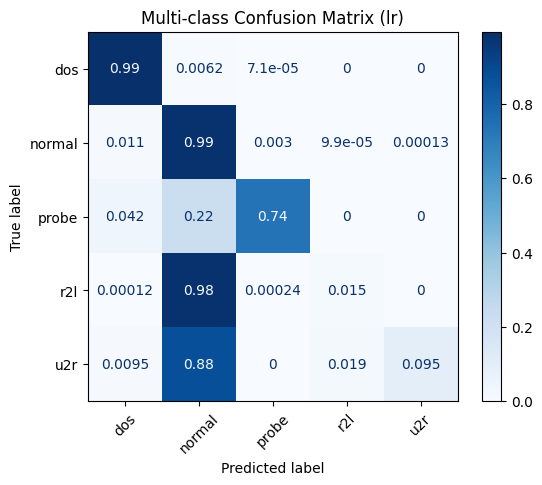

In [12]:
# Confusion Matrix
labels = sorted(y_test_family.unique())
plot_cm(y_test_family, y_pred_best, labels=labels, 
        title=f'Multi-class Confusion Matrix ({best_model_name})', 
        normalize='true')

In [13]:
# Sınıf bazında performans analizi
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test_family, y_pred_best, average=None, labels=labels
)

class_performance = pd.DataFrame({
    'class': labels,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'support': support
})

print('Sınıf bazında performans:')
print(class_performance.round(4))

Sınıf bazında performans:
    class  precision  recall  f1_score  support
0     dos     0.9961  0.9937    0.9949   112426
1  normal     0.7624  0.9854    0.8596    30296
2   probe     0.9375  0.7362    0.8248     2036
3     r2l     0.9612  0.0151    0.0298     8192
4     u2r     0.7143  0.0952    0.1681      105


## 6. Özellik Önemleri (Random Forest için)

In [14]:
# Eğer en iyi model Random Forest ise özellik önemlerini göster
if best_model_name == 'rf':
    # Özellik önemlerini al
    feature_names = best_model.named_steps['pre'].get_feature_names_out()
    importances = best_model.named_steps['clf'].feature_importances_
    
    # En önemli 20 özelliği göster
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print('En önemli 20 özellik (Multi-class):')
    print(feature_importance_df.head(20))
    
    # Görselleştir
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Özellik Önemi')
    plt.title('En Önemli 20 Özellik (Multi-class Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(f'Özellik önemleri sadece Random Forest modeli için gösterilir. En iyi model: {best_model_name}')

Özellik önemleri sadece Random Forest modeli için gösterilir. En iyi model: lr


## 7. Hata Analizi

In [15]:
# Yanlış sınıflandırılan örnekleri analiz et
misclassified = y_test_family != y_pred_best

print(f'Toplam yanlış sınıflandırma: {misclassified.sum()}')
print(f'Yanlış sınıflandırma oranı: {misclassified.mean():.4f}')

# En çok karıştırılan sınıf çiftleri
from collections import Counter

misclass_pairs = []
for true_label, pred_label in zip(y_test_family[misclassified], y_pred_best[misclassified]):
    misclass_pairs.append((true_label, pred_label))

most_common_errors = Counter(misclass_pairs).most_common(10)

print('\nEn sık karıştırılan sınıf çiftleri (gerçek -> tahmin):')
for (true_class, pred_class), count in most_common_errors:
    print(f'{true_class} -> {pred_class}: {count} kez')

Toplam yanlış sınıflandırma: 9848
Yanlış sınıflandırma oranı: 0.0643

En sık karıştırılan sınıf çiftleri (gerçek -> tahmin):
r2l -> normal: 8065 kez
dos -> normal: 697 kez
probe -> normal: 451 kez
normal -> dos: 346 kez
u2r -> normal: 92 kez
normal -> probe: 90 kez
probe -> dos: 86 kez
dos -> probe: 8 kez
normal -> u2r: 4 kez
normal -> r2l: 3 kez


## 8. Sonuçlar ve Değerlendirme

### Temel Bulgular:

1. **Model Performansları**: Yukarıdaki tabloda karşılaştırıldı
2. **En İyi Model**: Macro F1 skoruna göre belirlendi
3. **Sınıf Bazında Performans**: Her saldırı ailesi için ayrı ayrı analiz edildi
4. **Hata Analizi**: En sık karıştırılan sınıf çiftleri belirlendi

### Gözlemler:

- **DoS saldırıları** genellikle en kolay tespit edilen sınıftır
- **U2R ve R2L** saldırıları daha az örnekli olduğu için tespit edilmesi zordur
- **Probe** saldırıları orta düzeyde başarı ile tespit edilir

### Öneriler:

- Dengesiz sınıflar için daha gelişmiş örnekleme teknikleri kullanılabilir
- Ensemble yöntemleri (Voting, Stacking) denenebilir
- Özellik mühendisliği ile yeni özellikler türetilebilir
- Cost-sensitive learning yaklaşımları uygulanabilir